In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "high_z"
key = "z"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

13it [00:00, 121.90it/s]

25it [00:00, 120.71it/s]

38it [00:00, 121.21it/s]

51it [00:00, 121.02it/s]

64it [00:00, 122.00it/s]

75it [00:00, 115.80it/s]

87it [00:00, 116.96it/s]

101it [00:00, 122.95it/s]

115it [00:00, 127.10it/s]

129it [00:01, 130.18it/s]

144it [00:01, 132.88it/s]

159it [00:01, 135.24it/s]

173it [00:01, 127.17it/s]

186it [00:01, 117.17it/s]

200it [00:01, 122.06it/s]

213it [00:01, 110.82it/s]

225it [00:01, 104.68it/s]

237it [00:01, 107.82it/s]

251it [00:02, 114.54it/s]

265it [00:02, 119.95it/s]

279it [00:02, 124.51it/s]

293it [00:02, 127.57it/s]

307it [00:02, 130.24it/s]

321it [00:02, 132.25it/s]

335it [00:02, 133.71it/s]

349it [00:02, 135.03it/s]

363it [00:02, 135.30it/s]

377it [00:03, 126.15it/s]

390it [00:03, 124.91it/s]

403it [00:03, 124.67it/s]

416it [00:03, 125.16it/s]

429it [00:03, 125.00it/s]

443it [00:03, 127.45it/s]

457it [00:03, 130.06it/s]

471it [00:03, 131.41it/s]

485it [00:03, 128.66it/s]

498it [00:04, 113.81it/s]

510it [00:04, 114.38it/s]

522it [00:04, 111.36it/s]

536it [00:04, 116.84it/s]

549it [00:04, 118.78it/s]

562it [00:04, 119.91it/s]

575it [00:04, 120.80it/s]

589it [00:04, 124.30it/s]

602it [00:04, 125.13it/s]

615it [00:04, 126.22it/s]

628it [00:05, 124.84it/s]

641it [00:05, 124.14it/s]

655it [00:05, 126.82it/s]

669it [00:05, 128.61it/s]

683it [00:05, 130.36it/s]

697it [00:05, 132.62it/s]

711it [00:05, 134.74it/s]

726it [00:05, 136.80it/s]

740it [00:05, 137.13it/s]

754it [00:06, 135.98it/s]

769it [00:06, 137.36it/s]

783it [00:06, 137.70it/s]

797it [00:06, 137.54it/s]

811it [00:06, 131.00it/s]

825it [00:06, 132.41it/s]

839it [00:06, 133.47it/s]

853it [00:06, 134.96it/s]

868it [00:06, 136.51it/s]

882it [00:06, 130.55it/s]

896it [00:07, 132.43it/s]

911it [00:07, 135.12it/s]

925it [00:07, 136.47it/s]

939it [00:07, 132.08it/s]

953it [00:07, 132.72it/s]

968it [00:07, 135.31it/s]

983it [00:07, 136.88it/s]

997it [00:07, 131.21it/s]

1011it [00:07, 115.05it/s]

1023it [00:08, 102.46it/s]

1034it [00:08, 103.18it/s]

1046it [00:08, 105.99it/s]

1060it [00:08, 112.54it/s]

1072it [00:08, 106.50it/s]

1085it [00:08, 111.67it/s]

1097it [00:08, 98.44it/s] 

1108it [00:08, 101.56it/s]

1121it [00:09, 104.37it/s]

1132it [00:09, 96.53it/s] 

1142it [00:09, 90.25it/s]

1156it [00:09, 101.02it/s]

1171it [00:09, 110.15it/s]

1185it [00:09, 117.58it/s]

1200it [00:09, 123.80it/s]

1215it [00:09, 128.52it/s]

1229it [00:09, 128.86it/s]

1243it [00:10, 122.31it/s]

1255it [00:10, 123.43it/s]


0it [00:00, ?it/s]

13it [00:00, 123.83it/s]

Number of empty sat catalogs is 0


21it [00:00, 104.23it/s]

31it [00:00, 100.50it/s]

38it [00:00, 87.47it/s] 

48it [00:00, 89.65it/s]

58it [00:00, 91.51it/s]

68it [00:00, 92.40it/s]

78it [00:00, 93.46it/s]

88it [00:00, 93.30it/s]

98it [00:01, 93.46it/s]

108it [00:01, 93.06it/s]

120it [00:01, 99.49it/s]

133it [00:01, 102.48it/s]

144it [00:01, 95.96it/s] 

154it [00:01, 90.33it/s]

168it [00:01, 101.08it/s]

183it [00:01, 111.16it/s]

198it [00:01, 118.91it/s]

213it [00:02, 124.85it/s]

226it [00:02, 124.63it/s]

241it [00:02, 129.13it/s]

255it [00:02, 122.65it/s]

270it [00:02, 127.42it/s]

285it [00:02, 132.19it/s]

300it [00:02, 135.13it/s]

315it [00:02, 137.29it/s]

330it [00:02, 138.52it/s]

344it [00:03, 138.88it/s]

359it [00:03, 140.62it/s]

374it [00:03, 138.17it/s]

389it [00:03, 138.05it/s]

404it [00:03, 139.69it/s]

419it [00:03, 140.97it/s]

434it [00:03, 142.32it/s]

449it [00:03, 138.61it/s]

463it [00:03, 138.60it/s]

477it [00:03, 135.89it/s]

492it [00:04, 138.19it/s]

507it [00:04, 138.91it/s]

522it [00:04, 140.65it/s]

537it [00:04, 142.01it/s]

552it [00:04, 143.17it/s]

567it [00:04, 143.51it/s]

582it [00:04, 144.13it/s]

597it [00:04, 145.57it/s]

612it [00:04, 144.85it/s]

627it [00:05, 145.18it/s]

642it [00:05, 145.60it/s]

657it [00:05, 144.03it/s]

672it [00:05, 141.42it/s]

687it [00:05, 139.41it/s]

701it [00:05, 111.08it/s]

714it [00:05, 112.76it/s]

726it [00:05, 99.51it/s] 

741it [00:06, 109.87it/s]

753it [00:06, 104.78it/s]

768it [00:06, 113.53it/s]

782it [00:06, 118.77it/s]

797it [00:06, 125.32it/s]

812it [00:06, 130.05it/s]

827it [00:06, 134.32it/s]

842it [00:06, 137.24it/s]

856it [00:06, 137.18it/s]

870it [00:06, 133.08it/s]

885it [00:07, 135.32it/s]

900it [00:07, 136.40it/s]

914it [00:07, 137.02it/s]

929it [00:07, 138.01it/s]

943it [00:07, 127.17it/s]

957it [00:07, 129.37it/s]

971it [00:07, 115.37it/s]

986it [00:07, 122.61it/s]

1001it [00:07, 127.75it/s]

1015it [00:08, 112.20it/s]

1028it [00:08, 116.33it/s]

1042it [00:08, 120.45it/s]

1055it [00:08, 111.10it/s]

1068it [00:08, 114.06it/s]

1082it [00:08, 118.44it/s]

1095it [00:08, 113.28it/s]

1110it [00:08, 120.23it/s]

1125it [00:09, 125.53it/s]

1139it [00:09, 129.12it/s]

1153it [00:09, 131.91it/s]

1168it [00:09, 134.79it/s]

1182it [00:09, 136.09it/s]

1197it [00:09, 138.43it/s]

1212it [00:09, 141.00it/s]

1227it [00:09, 141.16it/s]

1242it [00:09, 140.26it/s]

1255it [00:09, 125.83it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

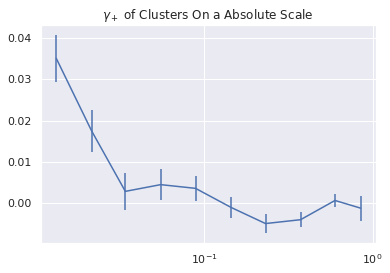

Aggregated xi:
[-7.2935 -8.7201 -2.1112 -5.6921 -7.7674  3.8532 26.3218 29.042  -4.9684
  3.4378]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -900.5566 -1915.8108 -2535.0907 -3710.3089 -5301.7609 -6797.5515
 -7736.8023 -7067.1864 -4186.7144  -448.5617]
------------------------------------------------------------------------------
Aggregated npairs:
[ 208.  498.  749. 1279. 2187. 3513. 5278. 7165. 8135. 2740.]
------------------------------------------------------------------------------
Mean xi:
[-0.0351 -0.0175 -0.0028 -0.0045 -0.0036  0.0011  0.005   0.0041 -0.0006
  0.0013]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3296 -3.847  -3.3846 -2.9009 -2.4242 -1.935  -1.4659 -0.9863 -0.5147
 -0.1637]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

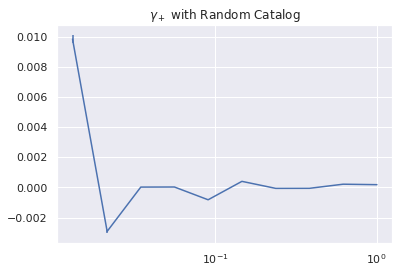

[ 9.8275e-03 -2.9159e-03  1.9740e-05  2.5301e-05 -8.2103e-04  3.9983e-04
 -6.5348e-05 -6.1656e-05  2.1127e-04  1.8010e-04]
[-2.7741e-04  8.2309e-05 -5.5721e-07 -7.1420e-07  2.3176e-05 -1.1286e-05
  1.8446e-06  1.7404e-06 -5.9637e-06 -5.0838e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

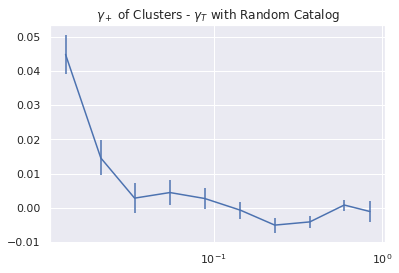

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

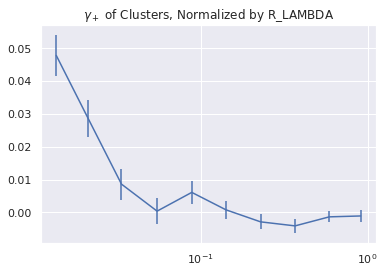

Aggregated xi:
[ -5.934   -8.9586  -5.4988  -0.379  -10.2264  -2.0975  12.804   25.5929
  10.8006   7.4011]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -532.5451 -1206.5861 -2166.6228 -2887.3002 -4068.9694 -5303.4668
 -6542.7726 -6226.8629 -4195.3371  -658.2522]
------------------------------------------------------------------------------
Aggregated npairs:
[ 124.  313.  638.  994. 1677. 2714. 4430. 6213. 7919. 6766.]
------------------------------------------------------------------------------
Mean xi:
[-0.0479 -0.0286 -0.0086 -0.0004 -0.0061 -0.0008  0.0029  0.0041  0.0014
  0.0011]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2947 -3.8549 -3.396  -2.9047 -2.4263 -1.9541 -1.4769 -1.0022 -0.5298
 -0.0973]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)